In [ ]:
!pip install optuna
import optuna
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.utils.data as utils
import time
import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 10.7 MB/s 
     |████████████████████████████████| 209 kB 48.5 MB/s 
     |████████████████████████████████| 81 kB 7.8 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 112 kB 51.8 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 147 kB 31.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5ad217c7f66bc25a1f4d352b5a9add84a7fa6dfb86612d7cd53a5037d830e407
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
resisten_kondolon3 = pd.read_csv("ISAT.csv",parse_dates=['Date'])

In [ ]:
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#Create Sequence Data

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(30);
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 21 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#Build Model

In [ ]:
class BiLSTM(nn.Module):
  
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)
        self.linear = nn.Linear(2*hidden_dim, output_dim)
        self.linear2 = nn.Linear(21,1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.linear(out)
        return out

#Hyperparameter Tuning

In [ ]:
# model = BiLSTM(input_dim=1, hidden_dim=8, output_dim=1, num_layers=8)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
# print("Hidden Layer:{}, LSTM: {}, Optimizer: {}, Min Mae: {}".format(model.hidden_dim, model.num_layers, optimizer.__class__.__name__, 0.1))

Hidden Layer:8, LSTM: 8, Optimizer: RMSprop, Min Mae: 0.1


In [ ]:
def build_model(params):
  model = BiLSTM(input_dim=1, hidden_dim=params['hidden'], output_dim=1, num_layers=params['lstm'])
  return model

def train_model(params,model):
  num_epochs = 300
  criterion = torch.nn.L1Loss()
  hist = np.zeros(num_epochs)
  min_loss = 100
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=0.001)
  for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    min_loss = hist.min()
    # print("Hidden Layer:{}, LSTM: {}, Optimizer: {}, Min Mae: {}".format(model.hidden_dim, model.num_layers, optimizer.__class__.__name__, min_loss))
  return min_loss

def objective(trial):
     params = {
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'lstm': trial.suggest_int("lstm", 1, 3, 1),
              'hidden': trial.suggest_int("hidden",8, 32, 8)
              }
    
     model = build_model(params)
    
     loss = train_model(params, model)

     return loss

In [ ]:
params = {
              'optimizer': ["Adam", "RMSprop", "SGD"],
              'lstm': [1,2,3],
              'hidden': [8,16,32]
              }
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.GridSampler(params))
study.optimize(objective, n_trials=27)

[I 2022-07-01 02:47:51,080] A new study created in memory with name: no-name-6e4fc68d-536a-4893-992e-f8fd06ae3c9d
[I 2022-07-01 02:49:58,728] Trial 0 finished with value: 0.01451956108212471 and parameters: {'optimizer': 'Adam', 'lstm': 2, 'hidden': 8}. Best is trial 0 with value: 0.01451956108212471.
[I 2022-07-01 02:52:47,054] Trial 1 finished with value: 0.01687699742615223 and parameters: {'optimizer': 'Adam', 'lstm': 3, 'hidden': 8}. Best is trial 0 with value: 0.01451956108212471.
[I 2022-07-01 02:54:34,899] Trial 2 finished with value: 0.019005853682756424 and parameters: {'optimizer': 'RMSprop', 'lstm': 2, 'hidden': 8}. Best is trial 0 with value: 0.01451956108212471.
[I 2022-07-01 02:55:29,802] Trial 3 finished with value: 0.01690039411187172 and parameters: {'optimizer': 'Adam', 'lstm': 1, 'hidden': 8}. Best is trial 0 with value: 0.01451956108212471.
[I 2022-07-01 03:05:56,824] Trial 4 finished with value: 0.027090290561318398 and parameters: {'optimizer': 'RMSprop', 'lstm':

In [ ]:
hyperparameter_tuning_20_seq = study.trials_dataframe()
hyperparameter_tuning_20_seq = hyperparameter_tuning_20_seq[['params_lstm','params_optimizer','params_hidden','value']]
hyperparameter_tuning_20_seq = hyperparameter_tuning_20_seq.sort_values(by=['params_lstm','params_optimizer','params_hidden']).reset_index()
hyperparameter_tuning_20_seq.drop('index',axis=1,inplace=True)
hyperparameter_tuning_20_seq.head()

,params_lstm,params_optimizer,params_hidden,value
0,1,Adam,8,0.113889
1,1,Adam,16,0.074009
2,1,Adam,32,0.078685
3,1,RMSprop,8,0.029224
4,1,RMSprop,16,0.030133


In [ ]:
hyperparameter_tuning_20_seq.to_excel('Hyperparameter Tuning 20 Sequences.xlsx')
hyperparameter_tuning_20_seq.to_csv('htune20.csv')

#Train Model Using Best Parameter

In [ ]:
model = BiLSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
y_train.shape

torch.Size([4301, 1])

In [ ]:
import time
num_epochs = 100
hist = np.zeros(num_epochs)
start_time = time.time()
y_test_pred1 = np.empty(shape=[0,1])
y_test_pred2 = np.empty(shape=[0,1])
y_test_pred3 = np.empty(shape=[0,1])
y_test_pred4 = np.empty(shape=[0,1])
y_test_pred5 = np.empty(shape=[0,1])
y_test_pred6 = np.empty(shape=[0,1])
y_test_pred7 = np.empty(shape=[0,1])
y_test_pred8 = np.empty(shape=[0,1])
y_test_pred9 = np.empty(shape=[0,1])
y_test_pred10 = np.empty(shape=[0,1])

for i in range(10):
  print("Percobaan Ke",i)
  model = BiLSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
  criterion = torch.nn.L1Loss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
  for t in range(num_epochs):
      y_train_pred = model(x_train,x_train)
      loss = criterion(y_train_pred, y_train)
      if t%10==0 or t==99:
        print("Epoch ", t, "MAE: ", loss.item())
      hist[t] = loss.item()
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
  if i==0:
    y_test_pred1 = model(x_test,x_test)
    y_test_pred1 = np.array(y_test_pred1.detach().numpy())
  if i==1:
    y_test_pred2 = model(x_test,x_test)
    y_test_pred2 = np.array(y_test_pred2.detach().numpy())
  if i==2:
    y_test_pred3=(model(x_test,x_test))
    y_test_pred3 = np.array(y_test_pred3.detach().numpy())
  if i==3:
    y_test_pred4=(model(x_test,x_test))
    y_test_pred4 = np.array(y_test_pred4.detach().numpy())
  if i==4:
    y_test_pred5=(model(x_test,x_test))
    y_test_pred5 = np.array(y_test_pred5.detach().numpy())
  if i==5:
    y_test_pred6=model(x_test,x_test)
    y_test_pred6 = np.array(y_test_pred6.detach().numpy())
  if i==6:
    y_test_pred7=(model(x_test,x_test))
    y_test_pred7 = np.array(y_test_pred7.detach().numpy())
  if i==7:
    y_test_pred8=(model(x_test,x_test))
    y_test_pred8 = np.array(y_test_pred8.detach().numpy())
  if i==8:
    y_test_pred9=(model(x_test,x_test))
    y_test_pred9 = np.array(y_test_pred9.detach().numpy())   
  if i==9:
    y_test_pred10=(model(x_test,x_test))
    y_test_pred10 = np.array(y_test_pred10.detach().numpy())   
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [ ]:
y_test_pred1 = scaler.inverse_transform(y_test_pred1)
y_test_pred2 = scaler.inverse_transform(y_test_pred2)
y_test_pred3 = scaler.inverse_transform(y_test_pred3)
y_test_pred4 = scaler.inverse_transform(y_test_pred4)
y_test_pred5 = scaler.inverse_transform(y_test_pred5)
y_test_pred6 = scaler.inverse_transform(y_test_pred6)
y_test_pred7 = scaler.inverse_transform(y_test_pred7)
y_test_pred8 = scaler.inverse_transform(y_test_pred8)
y_test_pred9 = scaler.inverse_transform(y_test_pred9)
y_test_pred10 = scaler.inverse_transform(y_test_pred10)

In [ ]:
percobaan = pd.DataFrame({'Pred 1':y_test_pred1[:,0],
                          'Pred 2':y_test_pred2[:,0],
                          'Pred 3':y_test_pred3[:,0],
                          'Pred 4':y_test_pred4[:,0],
                          'Pred 5':y_test_pred5[:,0],
                          'Pred 6':y_test_pred6[:,0],
                          'Pred 7':y_test_pred7[:,0],
                          'Pred 8':y_test_pred8[:,0],
                          'Pred 9':y_test_pred9[:,0],
                          'Pred 10':y_test_pred10[:,0]})
percobaan['Mean'] = percobaan[['Pred 1', 'Pred 2', 'Pred 3','Pred 4','Pred 5','Pred 6','Pred 7','Pred 8','Pred 9','Pred 10']].astype(float).sum(1)/10

In [ ]:
df = data.copy()
df = df.set_index('Date')
df = df[-30:]
df = df[['Close']]
df.rename(columns = {'Close':'Actual'}, inplace = True)
df['Mean Prediction'] = percobaan.Mean.values

In [ ]:
mean_absolute_error(df.Actual,df['Mean Prediction'])

201.19742675781256

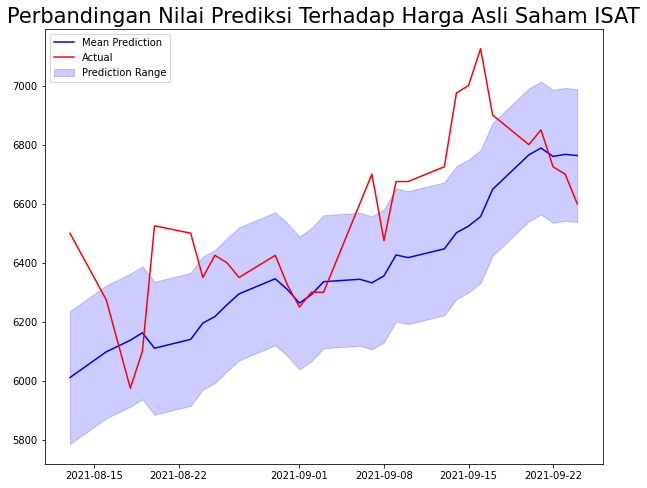

In [ ]:
X1 = df['Mean Prediction']
mu = X1.mean()
sigma = X1.std()

timestep = df.index

X1_plus_sigma = X1 + sigma
X1_minus_sigma = X1 - sigma

plt.figure(figsize=(10,8))
plt.title("Perbandingan Nilai Prediksi Terhadap Harga Asli Saham ISAT", fontdict={"fontsize":21})
plt.plot(timestep, X1, color = 'blue',label='Mean Prediction')
plt.plot(timestep,df.Actual,color='red',label='Actual')
plt.fill_between(timestep, X1_plus_sigma, X1_minus_sigma, alpha = 0.2, color = 'blue',label='Prediction Range')
ax = plt.gca()
plt.legend()
plt.show()

#Train

In [ ]:
model = BiLSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
criterion = torch.nn.L1Loss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
num_epochs = 100
hist = np.zeros(num_epochs)
for i in range(10):
  print("Percobaan Ke",i+1)
  model = BiLSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2)
  criterion = torch.nn.L1Loss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
  for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%10==0 or t==99:
      print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  train_denormalized = scaler.inverse_transform(y_train_pred.detach().numpy())  
  if i == 0:
    train1 = pd.DataFrame({'Train 1':train_denormalized[-20:,0]})
  elif i == 1:
    train2 = pd.DataFrame({'Train 2':train_denormalized[-20:,0]})
  elif i == 2:
    train3 = pd.DataFrame({'Train 3':train_denormalized[-20:,0]})
  elif i == 3:
    train4 = pd.DataFrame({'Train 4':train_denormalized[-20:,0]})
  elif i == 4:
    train5 = pd.DataFrame({'Train 5':train_denormalized[-20:,0]})
  elif i == 5:
    train6 = pd.DataFrame({'Train 6':train_denormalized[-20:,0]})
  elif i == 6:
    train7 = pd.DataFrame({'Train 7':train_denormalized[-20:,0]})
  elif i == 7:
    train8 = pd.DataFrame({'Train 8':train_denormalized[-20:,0]})
  elif i == 8:
    train9 = pd.DataFrame({'Train 9':train_denormalized[-20:,0]})
  elif i == 9:
    train10 = pd.DataFrame({'Train 10':train_denormalized[-20:,0]})

Percobaan Ke 1
Epoch  0 MAE:  0.3882347643375397
Epoch  10 MAE:  0.13074132800102234
Epoch  20 MAE:  0.11780823767185211
Epoch  30 MAE:  0.09088985621929169
Epoch  40 MAE:  0.055465128272771835
Epoch  50 MAE:  0.03427988663315773
Epoch  60 MAE:  0.01812855526804924
Epoch  70 MAE:  0.016003891825675964
Epoch  80 MAE:  0.01255588699132204
Epoch  90 MAE:  0.013780906796455383
Epoch  99 MAE:  0.012041880749166012
Percobaan Ke 2
Epoch  0 MAE:  0.41504526138305664
Epoch  10 MAE:  0.13584710657596588
Epoch  20 MAE:  0.11347976326942444
Epoch  30 MAE:  0.10975900292396545
Epoch  40 MAE:  0.034597694873809814
Epoch  50 MAE:  0.016588225960731506
Epoch  60 MAE:  0.015072789043188095
Epoch  70 MAE:  0.01400184165686369
Epoch  80 MAE:  0.012698757462203503
Epoch  90 MAE:  0.011747468262910843
Epoch  99 MAE:  0.011554526165127754
Percobaan Ke 3
Epoch  0 MAE:  0.4449847340583801
Epoch  10 MAE:  0.11898479610681534
Epoch  20 MAE:  0.10125541687011719
Epoch  30 MAE:  0.019675904884934425
Epoch  40 MAE

#Save Train To DF

In [ ]:
dfTrainList = [train1,train2,train3,train4,train5,train6,train7,train8,train9,train10]
dfTrain = pd.concat(dfTrainList, join='outer', axis=1)
dfTrain['Mean'] = dfTrain[['Train 1', 'Train 2', 'Train 3','Train 4','Train 5','Train 6','Train 7','Train 8','Train 9','Train 10']].astype(float).sum(1)/10
dfTrain.to_excel('Mean.xlsx')

#Predict Test Data

In [ ]:
future = 5
lookback = 20
model.eval()
x_train = torch.FloatTensor(x_train).view(-1)
test_inputs = list(x_train[-lookback:])
for i in range(future):
  test_seq = [[[a] for a in test_inputs[-lookback:]]]
  test_seq = torch.FloatTensor(test_seq)
  with torch.no_grad():
    test_inputs.append(model(test_seq).item())
# y_test_pred = model(x_test,x_test)

In [ ]:
test_actual = y_test[:future]
test_actual = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1)).flatten()
test_pred = scaler.inverse_transform(np.array(test_inputs).reshape(-1, 1)).flatten()
test_pred = test_pred[-future:]

In [ ]:
tes_denormalized = scaler.inverse_transform(np.array(test_inputs).reshape(-1, 1)).flatten()

In [ ]:
mean_absolute_error(test_actual,test_pred)

216.80784363746625

#Save Test To DF

In [ ]:
test1 = pd.DataFrame({'Tes 1':tes_denormalized})

In [ ]:
test2 = pd.DataFrame({'Tes 2':tes_denormalized})

In [ ]:
test3 = pd.DataFrame({'Tes 3':tes_denormalized})

In [ ]:
test4 = pd.DataFrame({'Tes 4':tes_denormalized})

In [ ]:
test5 = pd.DataFrame({'Tes 5':tes_denormalized})

In [ ]:
test6 = pd.DataFrame({'Tes 6':tes_denormalized})

In [ ]:
test7 = pd.DataFrame({'Tes 7':tes_denormalized})

In [ ]:
test8 = pd.DataFrame({'Tes 8':tes_denormalized})

In [ ]:
test9 = pd.DataFrame({'Tes 9':tes_denormalized})

In [ ]:
test10 = pd.DataFrame({'Tes 10':tes_denormalized})

In [ ]:
dfTestList = [test1,test2,test3,test4,test5,test6,test7,test8,test9,test10]
dfTest = pd.concat(dfTestList, join='outer', axis=1)

In [ ]:
dfTest['Mean'] = dfTest[['Tes 1', 'Tes 2', 'Tes 3','Tes 4','Tes 5','Tes 6','Tes 7','Tes 8','Tes 9','Tes 10']].astype(float).sum(1)/10

In [ ]:
dfTest.to_excel('Mean.xlsx')

In [ ]:
mean_absolute_error(y_test.detach().numpy(),y_test_pred.detach().numpy())

In [ ]:
y_test_invert = y_test.clone()
y_test_invert = scaler.inverse_transform(y_test_invert.detach().numpy())
y_test_pred_invert = y_test_pred.clone()
y_test_pred_invert = scaler.inverse_transform(y_test_pred_invert.detach().numpy())

In [ ]:
predicted = pd.DataFrame({'Predicted': y_test_pred_invert[:, 0]})
df = data.copy()
df = df.set_index('Date')
df = df[-30:]
df = df[['Close']]
df.rename(columns = {'Close':'Actual'}, inplace = True)
df['BiLSTM'] = predicted.values

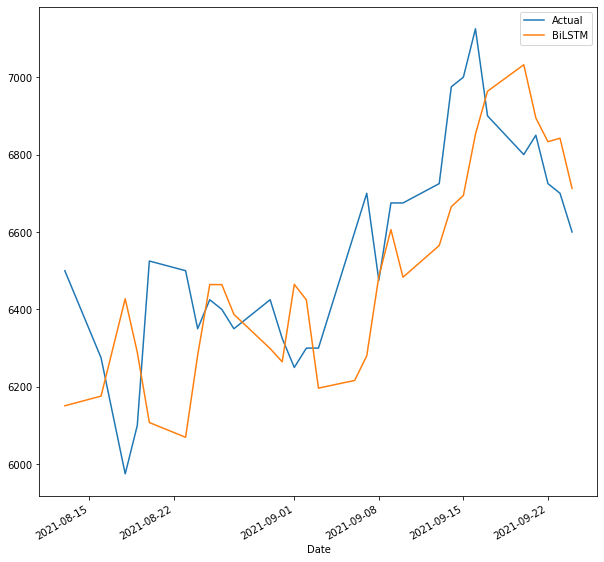

In [ ]:
df.plot(y=["Actual","BiLSTM"],
        kind="line", figsize=(10, 10),use_index=True)

In [ ]:
mean_absolute_error(y_test_invert,y_test_pred_invert)

150.49352

In [ ]:
df = pd.read_excel('/content/Pengujian Model RNN, LSTM, BiLSTM.xlsx')

In [ ]:
mean_absolute_error(df['Actual'],df['BiLSTM'])

188.071923828125

#MAE

In [ ]:
dfTesting = pd.read_excel('Mean Testing.xlsx')

In [ ]:
actual = data.Close[-30:-25]
actual

4322    6500.0
4323    6275.0
4324    5975.0
4325    6100.0
4326    6525.0
Name: Close, dtype: float64

In [ ]:
mean_absolute_error(data.Close[-30:-25],dfTesting.Mean[-5:])

254.6462327241894

#Plotting


In [ ]:
priceActual = data.copy()
priceActual = priceActual.set_index('Date')
priceActual = priceActual[ :'2021-09-24']
priceActual = priceActual['Close'][-50:-25]
predicted = dfTrain['Mean']
predicted = predicted.append(dfTesting.Mean[-5:])
df = pd.DataFrame({'Date':priceActual.index,
                   'Actual':priceActual.values,
                   'Predicted':predicted.values})
df = df.set_index('Date')
# df = df.shift(2)
# df.fillna(0,inplace=True)
df

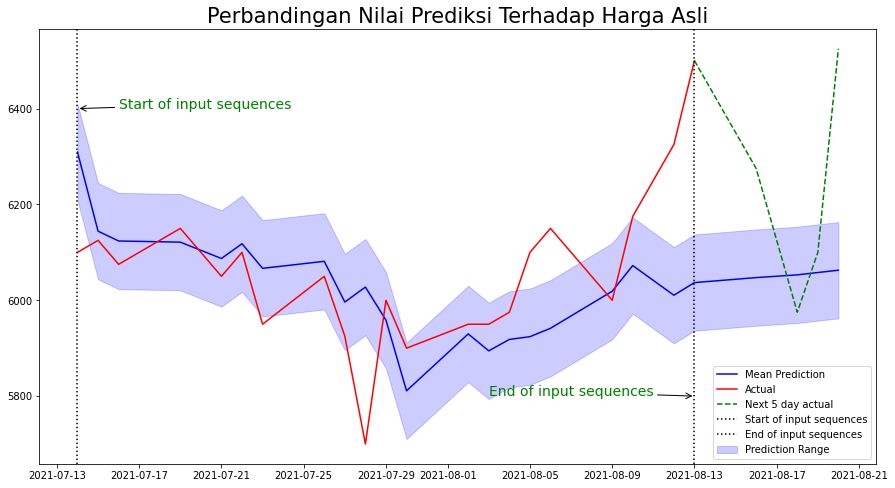

In [ ]:
X1 = df['Predicted']
mu = X1.mean()
sigma = X1.std()

timestep = df.index

X1_plus_sigma = X1 + sigma
X1_minus_sigma = X1 - sigma

plt.figure(figsize=(15,8))
plt.title("Perbandingan Nilai Prediksi Terhadap Harga Asli", fontdict={"fontsize":21})
plt.plot(timestep, X1, color = 'blue',label='Mean Prediction')
plt.plot(timestep[:21],df.Actual[:21],color='red',label='Actual')
plt.plot(timestep[20:],df.Actual[20:],color='green',label='Next 5 day actual',linestyle='--')
plt.axvline(timestep[0],color='black',label='Start of input sequences', linestyle='dotted')
plt.axvline(timestep[20],color='black',label='End of input sequences', linestyle='dotted')
plt.annotate('Start of input sequences', xy = (timestep[0],6400), 
             fontsize = 14, xytext = (timestep[2], 6400), 
             arrowprops = dict(facecolor = 'red',arrowstyle='->'),
             color = 'g')
plt.annotate('End of input sequences', xy = (timestep[20],5800), 
             fontsize = 14, xytext = (timestep[13], 5800), 
             arrowprops = dict(facecolor = 'red',arrowstyle='->'),
             color = 'g')
plt.fill_between(timestep, X1_plus_sigma, X1_minus_sigma, alpha = 0.2, color = 'blue',label='Prediction Range')
plt.legend()
plt.show()